In [1]:
import sys
sys.path.insert(0, '../Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from pysr import PySRRegressor
import sympy 
import pandas as pd

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:

# Carga los archivos .xlsx
file1 = '../DataExperiments/WT_in_LB_data_s1.XLSX'
file2 = '../DataExperiments/different_conditions_data_s2.XLSX'

# Lee las hojas de los archivos
df1 = pd.read_excel(file1, engine='openpyxl')  # Especifica la hoja si es necesario: sheet_name='nombre_hoja'
df2 = pd.read_excel(file2, engine='openpyxl')

# Cambiar la fila 0 a la nueva cabecera
df2.columns = df2.iloc[0]  # Establecer la primera fila como nueva cabecera
df2 = df2[1:]  # Eliminar la primera fila

# Reiniciar los índices (opcional, si quieres que empiece desde 0)
df2 = df2.reset_index(drop=True)

# Muestra los DataFrames
print("Archivo 1:")
display(df1)

print("Archivo 2:")
display(df2)


Archivo 1:


,Cycle Nr.,Time [s],Temp. [°C],G4,G5,G6,G7,G8,G9,G10,G11,G12,H1,H2,H3,H4,H5,H6
0,1,0.0,30.8,0.0922,0.0928,0.0928,0.0931,0.0928,0.0927,0.0916,0.0921,0.0911,0.0936,0.0925,0.0918,0.0929,0.0931,0.0931
1,2,678.6,30.7,0.0951,0.0957,0.0959,0.0959,0.0957,0.0953,0.0947,0.0951,0.0941,0.0970,0.0958,0.0951,0.0963,0.0963,0.0962
2,3,1357.1,30.4,0.0951,0.0958,0.0957,0.0960,0.0958,0.0954,0.0947,0.0951,0.0943,0.0971,0.0959,0.0952,0.0965,0.0964,0.0963
3,4,2035.7,30.2,0.0955,0.0962,0.0961,0.0965,0.0964,0.0958,0.0950,0.0957,0.0947,0.0975,0.0964,0.0957,0.0969,0.0969,0.0969
4,5,2714.2,30.0,0.0960,0.0969,0.0965,0.0968,0.0968,0.0964,0.0956,0.0963,0.0953,0.0981,0.0969,0.0961,0.0974,0.0973,0.0973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,495,335199.8,30.8,0.8186,0.8214,0.8188,0.8198,0.8221,0.8201,0.8296,0.8418,0.8292,0.4360,0.7711,0.8043,0.8181,0.8181,0.8153
495,496,335878.3,30.9,0.8184,0.8222,0.8185,0.8178,0.8201,0.8182,0.8277,0.8379,0.8274,0.4379,0.7729,0.8038,0.8198,0.8180,0.8154
496,497,336556.8,30.8,0.8183,0.8222,0.8169,0.8204,0.8214,0.8186,0.8287,0.8409,0.8289,0.4304,0.7719,0.8040,0.8187,0.8172,0.8154
497,498,337235.3,30.8,0.8172,0.8211,0.8194,0.8206,0.8227,0.8201,0.8303,0.8417,0.8280,0.4321,0.7717,0.8043,0.8194,0.8173,0.8143


Archivo 2:


,Cycle Nr.,Time [s],Temp. [°C],A1,A2,A3,A4,A5,A6,A7,...,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11
0,1,0,30,0.0929,0.0971,0.0948,0.0961,0.0939,0.0934,0.0938,...,0.0913,0.0914,0.0924,0.0916,0.0925,0.0921,0.092,0.093,0.0927,0.093
1,2,678.6,30.5,0.0925,0.0962,0.0946,0.0953,0.0935,0.0931,0.0933,...,0.0913,0.0916,0.0926,0.092,0.0914,0.0921,0.0921,0.0931,0.0932,0.0925
2,3,1357.2,30.1,0.0926,0.0962,0.095,0.0954,0.0936,0.0932,0.0932,...,0.0916,0.0917,0.0927,0.0918,0.0917,0.0922,0.0923,0.0932,0.0932,0.0927
3,4,2035.8,30,0.0928,0.0981,0.0949,0.0956,0.0937,0.0934,0.0934,...,0.092,0.0921,0.0931,0.0922,0.0922,0.0928,0.0926,0.0936,0.0937,0.093
4,5,2714.4,30.3,0.0933,0.0985,0.0953,0.096,0.0942,0.0939,0.0938,...,0.0925,0.0927,0.0937,0.0928,0.093,0.0933,0.0933,0.0943,0.0944,0.0938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,338,228685.2,29.9,0.5954,0.6453,0.6513,0.6593,0.6599,0.6576,0.5901,...,0.0926,0.0926,0.0935,0.0924,0.0949,1.0018,0.9769,0.9848,0.9871,0.9972
338,339,229363.7,29.8,0.5937,0.6448,0.6495,0.6568,0.6572,0.6564,0.5898,...,0.0926,0.0927,0.0934,0.0926,0.0953,1.0017,0.98,0.9857,0.9868,0.9976
339,340,230042.3,29.9,0.5923,0.6429,0.6487,0.6575,0.6589,0.6572,0.5889,...,0.0925,0.0925,0.0933,0.0923,0.0947,1.0009,0.9758,0.9833,0.9846,0.9963
340,341,230720.9,30.3,0.5912,0.6419,0.6484,0.6568,0.657,0.6548,0.5888,...,0.0923,0.0924,0.0932,0.0921,0.0942,1.0004,0.9763,0.9843,0.9845,0.9981


In [3]:
df2.iloc[:, 9:15]


,A7,A8,A9,A10,A11,A12
0,0.0938,0.0933,0.0947,0.094,0.0945,0.0923
1,0.0933,0.0932,0.0948,0.0937,0.0937,0.0923
2,0.0932,0.0933,0.0948,0.0939,0.0939,0.0927
3,0.0934,0.0935,0.095,0.0941,0.0941,0.0926
4,0.0938,0.0939,0.0954,0.0945,0.0945,0.0929
...,...,...,...,...,...,...
337,0.5901,0.6007,0.5678,0.5227,0.5631,0.308
338,0.5898,0.6002,0.5683,0.5222,0.5616,0.3055
339,0.5889,0.5999,0.5681,0.5221,0.5621,0.3051
340,0.5888,0.5992,0.5675,0.5211,0.561,0.3032


In [4]:
c=-1
P_exp=np.array(df2.iloc[:, 9:14])
T_exp=np.array(df2['Time [s]'])

T_max=max(T_exp)
T_exp=T_exp/max(T_exp)
N_exp=P_exp.shape[1]
N_exp,T_max

(5, 231399.5)

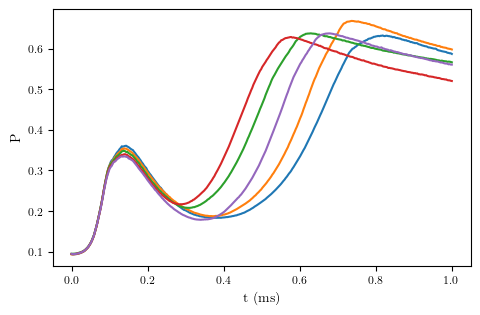

In [5]:
for i in range(N_exp):
    plt.plot(T_exp,P_exp[:, i])
plt.xlabel('t (ms)')
plt.ylabel('P ')
plt.show()

In [6]:
N_f = 1000 # Number of residual point
N_d = 500 #Number of data

P_star = P_exp.T.flatten().reshape([-1,1])
P0=P_exp[0,:]
T_meshgrid, P0_meshgrid, = np.meshgrid(T_exp, P0)
X_star = np.hstack((T_meshgrid.flatten()[:,None], P0_meshgrid.flatten()[:,None]))
u_star=np.hstack((P_star,P0_meshgrid.flatten()[:,None]))


# T_star = np.tile(T_exp,N_exp).reshape([-1,1])

# Doman bounds
lb = X_star.min(0)
lb[1]=lb[1]
ub = X_star.max(0) 
ub[1]=ub[1]


# Initial Condition
xx0 = X_star[::len(T_exp)]
uu0 = P_star[::len(T_exp)]

xx1= np.hstack((np.ones(len(P0)).reshape([-1,1]), P0.reshape([-1,1])))

xx01=np.vstack((xx0, xx1))
uu01=np.array([1]*N_exp+[0]*N_exp).reshape([-1,1])

# Additional data
idx = np.random.choice(P_star.shape[0], N_d-len(uu0), replace=False)
xxd = X_star[idx]
uud = P_star[idx]

X_u_train = np.concatenate((xx0,xxd))
P_train = np.concatenate((uu0,uud))

X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))

X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
P_train_tf =   tf.convert_to_tensor(P_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)
P_star_tf = tf.convert_to_tensor(P_star, dtype=tf.float32)
xx01_tf = tf.convert_to_tensor(xx01, dtype=tf.float32)
uu01_tf = tf.convert_to_tensor(uu01, dtype=tf.float32)

2024-12-29 10:54:47.029472: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2024-12-29 10:54:47.029985: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublas64_11.dll'; dlerror: cublas64_11.dll not found
2024-12-29 10:54:47.030299: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublasLt64_11.dll'; dlerror: cublasLt64_11.dll not found
2024-12-29 10:54:47.030594: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cufft64_10.dll'; dlerror: cufft64_10.dll not found
2024-12-29 10:54:47.030906: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'curand64_10.dll'; dlerror: curand64_10.dll not found
2024-12-29 10:54:47.031190: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dyna

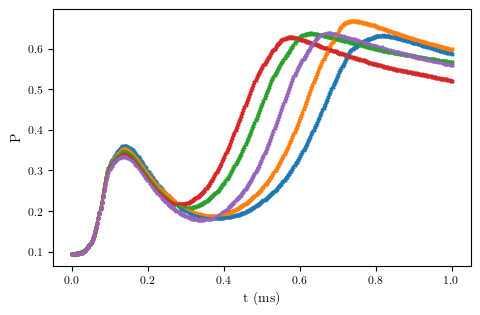

In [7]:
L_exp=len(P_exp[:,1])
for i in range(N_exp):
    plt.plot(X_star[L_exp*i:L_exp*(i+1)][:,0],P_exp[:, i])
    plt.scatter(X_star[L_exp*i:L_exp*(i+1)][:,0],P_star[L_exp*i:L_exp*(i+1)], marker='x', s=5)

plt.xlabel('t (ms)')
plt.ylabel('P ')
plt.show()

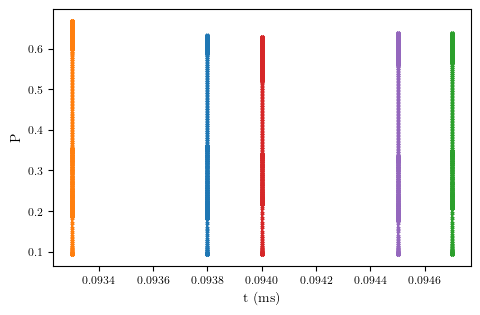

In [8]:
L_exp=len(P_exp[:,1])
for i in range(N_exp):
    plt.plot(X_star[L_exp*i:L_exp*(i+1)][:,1],P_exp[:, i])
    plt.scatter(X_star[L_exp*i:L_exp*(i+1)][:,1],P_star[L_exp*i:L_exp*(i+1)], marker='x', s=5)

plt.xlabel('t (ms)')
plt.ylabel('P ')
plt.show()

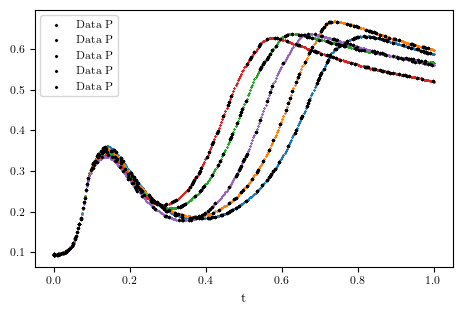

In [ ]:
L_exp=len(P_exp[:,1])
for i in range(N_exp):
    plt.scatter(X_star[L_exp*i:L_exp*(i+1)][:,0],P_star[L_exp*i:L_exp*(i+1)], marker='x', s=1)
    plt.scatter(X_u_train[:,0], P_train, marker='x', s=2, color='black',label='Data P')

plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# #plt.savefig('figures/P_phi.pdf')
plt.show()

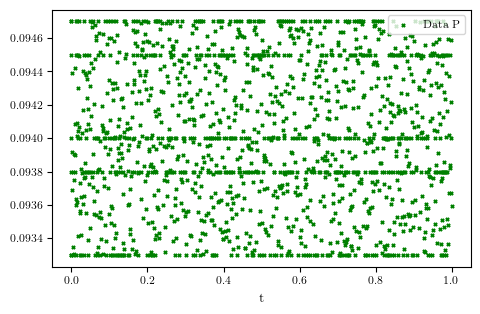

In [ ]:

plt.scatter(X_f_train_tf[:,0], X_f_train_tf[:,1], s=5, marker='x', color='green',label='Data P')


plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# #plt.savefig('figures/P_phi.pdf')
plt.show()

In [11]:
np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
#os.environ[‘TF_ENABLE_AUTO_MIXED_PRECISION’] = ‘1’



# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = 2.0*(X - lb)/(ub - lb) - 1.0
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b 


def net(t, w, b):
    p = DNN(t, w, b)
    return p

def loss_weight(N_r, N_b):
    alpha_b = tf.Variable(tf.reshape(tf.repeat(1000.0, N_b), (N_b, -1))) 
    alpha_r = tf.Variable(tf.ones(shape=[N_r, 2]), dtype=tf.float32)
    alpha_0 = tf.Variable(tf.reshape(tf.repeat(1000.0, N_exp*2), (N_exp*2, -1))) 
    return alpha_r, alpha_b, alpha_0


#@tf.function(jit_compile=True)
@tf.function()
def net_f(X_f, W_p, b_p, W_phi, b_phi, lnv):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([X_f])
        u=net(X_f, W_p, b_p)

        p=tf.exp(u)
        t=X_f[...,0:1]


        phi=net(tf.concat([p, t],1), W_phi, b_phi)


    p_t = tape1.gradient(p, X_f)[...,0:1]
    # s_t = tape1.gradient(s, X_f)[...,0:1]

    f_p = p_t - phi*p 
    # f_s = s_t + m*p*s
    
    return f_p




#@tf.function()
@tf.function()
def train_step(W_p, b_p,  W_phi, b_phi,  X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv, opt):

    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W_p, b_p, W_phi, b_phi, lambda_b, lambda_r, lambda_0, lnv])
        u_nn = net(X_u_train_tf, W_p, b_p) 
        lnp=u_nn[:,0:1]
        p_nn=tf.exp(lnp)
        f_p = net_f(X_f_train_tf, W_p, b_p, W_phi, b_phi, lnv)




        loss_p = tf.square(lambda_b*(p_nn - P_train_tf))
        # loss_0s = tf.square(lambda_0*(s_00 - uu01_tf))
        loss_fp = tf.square(lambda_r[0:1]*f_p) 
        # loss_fs = tf.square(lambda_r[1:2]*f_s) 


        loss =  tf.reduce_mean(loss_p) + tf.reduce_mean(loss_fp)
        
    grads_p = tape.gradient(loss, train_vars(W_p, b_p))
    grads_phi = tape.gradient(loss, train_vars(W_phi, b_phi))
    # grads_lnv = tape.gradient(loss, lnv)
    grads_u = tape.gradient(loss, lambda_r)
    grads_b = tape.gradient(loss, lambda_b)
    # grads_0 = tape.gradient(loss, lambda_0)


    opt.apply_gradients(zip(grads_p, train_vars(W_p, b_p)))
    opt.apply_gradients(zip(grads_phi, train_vars(W_phi, b_phi)))
    # opt.apply_gradients(zip([grads_lnv], [lnv]))
    opt.apply_gradients(zip([-grads_u], [lambda_r]))
    opt.apply_gradients(zip([-grads_b], [lambda_b]))
    # opt.apply_gradients(zip([-grads_0], [lambda_0]))

   
    return loss, tf.reduce_mean(tf.square((p_nn - P_train_tf))), tf.reduce_mean(tf.square(f_p))


layers = [2, 20, 20, 1]

L = len(layers)
W_p = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_p = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

layers = [2, 20, 20, 1]


W_phi = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_phi = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

lnv = tf.Variable(tf.reshape(tf.repeat(1.0, 2), (2, -1)), dtype=tf.float32) 
lambda_r, lambda_b, lambda_0 = loss_weight(N_f, N_d)



In [12]:
lr = 2e-3
# Nmax = 15000
# Nmax = 150000
Nmax=3*10**5
# Nmax=20000



optimizer = tf.optimizers.Adam(learning_rate=lr)
optimizer2 = tf.optimizers.Adam(learning_rate=lr/10)
# optimizer3 = tf.optimizers.Adam(learning_rate=lr/100)
# optimizer3 = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
optimizer3 = tf.optimizers.Adam(learning_rate=lr/50)

# optimizer3 = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9, clipnorm=10.0)


start_time = time.time()
n=0
loss = []
loss_d = []
loss_fisp = []
loss_fiss = []
loss_reg=[]
# loss_fisa = []

# Make a new Function and ConcreteFunction for each optimizer.
train_step_1 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf,  lambda_r, lambda_b, lambda_0, lnv, optimizer)
train_step_2 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv, optimizer)
train_step_3 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv, optimizer)


In [13]:
Nmax=10**5


while n <= Nmax:
    # if n<10**5:
    loss_, loss_p, loss_fp = train_step_1(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv)
    # elif n< 2*10**5:
    #     loss_, loss_p, loss_fp = train_step_2(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv)
    # else:
    #     loss_, loss_p, loss_fp = train_step_3(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv)

    loss.append(loss_)
    loss_d.append(loss_p)
    loss_fisp.append(loss_fp)
    # loss_fiss.append(loss_fs)
    # loss_fisa.append(loss_fa)



    if n % 10 == 0:

        print(f"Iteration is: {n}")
        print(f"Total loss is: {loss_}")
        print(f"Data loss is: {loss_p}")
        print(f"Physicial loss of p is: {loss_fp}")
        # print(f"Physicial loss of s is: {loss_fs}")
        # if n%10000 ==0:
        #     loss_reg_=eval(W_p, b_p, W_phi_s, b_phi_s)
        #     loss_reg.append(loss_reg_)
        # print(f"Physicial loss of a is: {loss_fa}")

    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

Iteration is: 0
Total loss is: 955732.6875
Data loss is: 0.9557307362556458
Physicial loss of p is: 1.9704794883728027
Iteration is: 10
Total loss is: 269431.15625
Data loss is: 0.26942136883735657
Physicial loss of p is: 0.06904574483633041
Iteration is: 20
Total loss is: 86210.96875
Data loss is: 0.0862031802535057
Physicial loss of p is: 0.07781274616718292
Iteration is: 30
Total loss is: 33564.33203125
Data loss is: 0.03355913609266281
Physicial loss of p is: 0.02839912474155426
Iteration is: 40
Total loss is: 12887.9794921875
Data loss is: 0.01288565807044506
Physicial loss of p is: 0.02648717723786831
Iteration is: 50
Total loss is: 10809.953125
Data loss is: 0.010807907208800316
Physicial loss of p is: 0.030352439731359482
Iteration is: 60
Total loss is: 11226.580078125
Data loss is: 0.011224004440009594
Physicial loss of p is: 0.019839216023683548
Iteration is: 70
Total loss is: 10943.6689453125
Data loss is: 0.010940699838101864
Physicial loss of p is: 0.018736964091658592
Ite

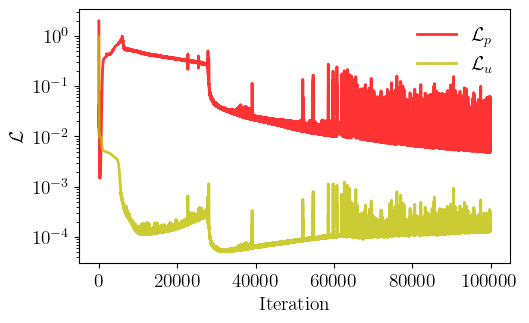

In [156]:
# Nmax=len(loss)
it = np.arange(0,Nmax, 1)
loss_list = [loss[i].numpy() for i in range(0,Nmax)]
loss_data_list = [loss_d[i].numpy() for i in range(0,Nmax)]

loss_phip_list = [loss_fisp[i].numpy() for i in range(0,Nmax)]
# loss_phis_list = [loss_fiss[i].numpy() for i in range(0,Nmax)]



plt.semilogy(it, np.asarray(loss_phip_list), 'r-', linewidth = 2, alpha=0.8,  label = '$\mathcal{L}_p$')    
# plt.semilogy(it, np.asarray(loss_phis_list), 'g-', linewidth = 2, alpha=0.8,  label = '$\mathcal{L}_s$')   
plt.semilogy(it, np.asarray(loss_data_list), 'y-', linewidth = 2, alpha=0.8, label = '$\mathcal{L}_u$')  


plt.legend(fontsize=14, ncols=1, frameon=False)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('$\mathcal{L}$', fontsize=14)    
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Img/601/Loss_split.png')
plt.savefig('../Img/601/Loss_split.pdf')
plt.savefig('../Img/601/Loss_split.svg')
plt.show()

In [197]:
def predict(X_star_tf, w, b):
    u_pred = net(X_star_tf, w, b)
    return u_pred

## Evaluating total function
X_star_tf = tf.convert_to_tensor(X_star, dtype=tf.float32)    
u_pred = predict(X_star_tf, W_p, b_p)
p=tf.exp(u_pred)
t=X_star_tf[...,0:1]


phi=predict(tf.concat([p, t],1), W_phi, b_phi)


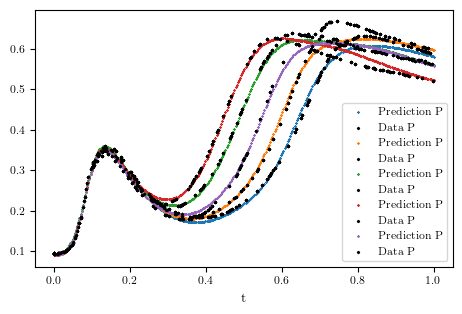

In [158]:
for i in range(N_exp):
    plt.scatter(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], p[L_exp*i:L_exp*(i+1)], marker='x', s=1,  label='Prediction P')
    plt.scatter(X_u_train[:,0], P_train, marker='x', s=2, color='black',label='Data P')

plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# #plt.savefig('figures/P_phi.pdf')
plt.show()

In [159]:
# for i in range(N_exp):
#     plt.scatter(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], s[L_exp*i:L_exp*(i+1)], marker='x', s=1,  label='Prediction S')


# plt.legend()
# plt.xlabel('t')
# plt.yscale('log')
# # plt.xscale('log')

# # plt.ylabel('P')
# # #plt.savefig('figures/P_phi.pdf')
# plt.show()

In [160]:
colors = plt.cm.tab10.colors


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


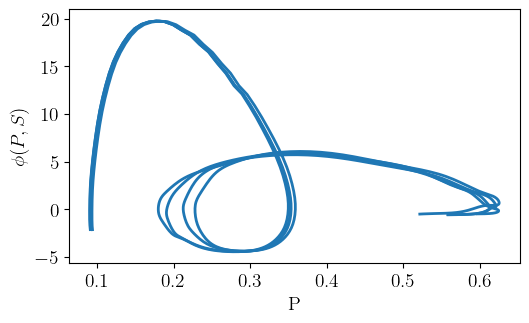

In [161]:
for i in range(1, N_exp):
    plt.plot(p[L_exp*i:L_exp*(i+1)][:,0], phi[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[0])
    # plt.plot(s[L_exp*i:L_exp*(i+1)][:,0], phi[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[1])

# plt.plot(p, phi,linewidth=3)
# plt.plot(s, phi, linewidth=3)
# plt.scatter(X_f_train_tf, np.zeros_like(X_f_train), marker='x', s=5, color='green',label='$f$')

# plt.legend(fontsize=14, ncols=1, frameon=False,  bbox_to_anchor=(1, 0.7))
plt.legend(fontsize=14, ncols=1, frameon=False)

plt.xlabel('P', fontsize=14)
# plt.text(0.3, -0.2, r'$\mathbf{s}$', fontsize=24, color=colors[1], ha='center', transform=plt.gca().transAxes)

plt.ylabel('$\phi(P, S)$', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Img/601/Result_phi.png')
plt.savefig('../Img/601/Result_phi.pdf')
plt.savefig('../Img/601/Result_phi.svg')
plt.show()

In [162]:
P0, np.mean(P0)


(array([0.09380000084638596, 0.093299999833107, 0.09470000118017197,
        0.09399999678134918, 0.09449999779462814], dtype=object),
 0.09405999928712845)

In [163]:
P0

array([0.09380000084638596, 0.093299999833107, 0.09470000118017197,
       0.09399999678134918, 0.09449999779462814], dtype=object)

In [164]:
Nt=1000
T_int=np.zeros(Nt)
P_int=np.zeros(Nt)
# S_int=np.zeros(Nt)


dt=0.001

T_int[0]=0
P_int[0]=np.mean(P0) #Initial conditions
# P_int[0]=np.array(p[0]) #Initial conditions

# S_int[0]=np.array(s[0]) #Initial conditions




for i in range(1,Nt):

    PT=tf.concat([tf.convert_to_tensor(P_int[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(T_int[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    # PHI_S=tf.exp(net(PSA, W_a, b_a))
    
    PHI=net(PT, W_phi, b_phi)
    # REVISAAAAAR
    # PHI_S=tf.exp(predict(tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32) , W_phi, b_phi))
    P_int[i]=P_int[i-1]+P_int[i-1]*PHI*dt
    # S_int[i]=S_int[i-1]-P_int[i-1]*S_int[i-1]*PHI_S*dt
    T_int[i]=T_int[i-1]+dt

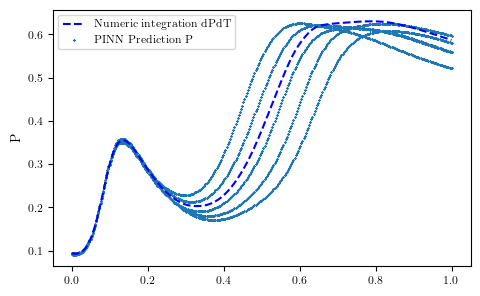

In [165]:
plt.plot(T_int, P_int, color='blue', linestyle='--', label='Numeric integration dPdT')
# plt.plot(T_int, S_int, color='orange', linestyle='--', label='Numeric integration dSdT')


plt.scatter(X_star_tf[:,0], p, marker='x', s=1,  label='PINN Prediction P')
# plt.scatter(X_star_tf[:,0], s, marker='x', s=1,  label='PINN Prediction S')
# plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()

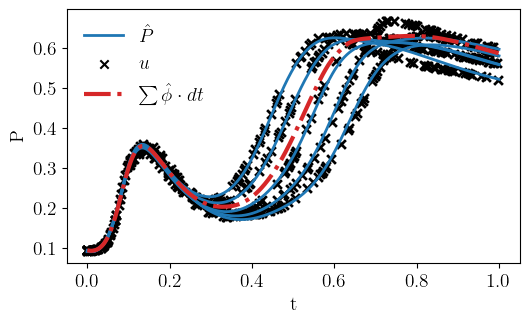

In [166]:


i=0
plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], p[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2, label='$\hat{P}$')
# plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], s[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2, label='$\hat{S}$')

plt.scatter(X_u_train[:,0], P_train, marker='x', color='black',label='$u$')
for i in range(1, N_exp):
    plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], p[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[0])
    # plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], s[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[1])

    plt.scatter(X_u_train[:,0], P_train, marker='x',  color='black')

plt.plot(T_int, P_int, linestyle='-.',linewidth=3, color=colors[3], label='$\sum \hat{\phi} \cdot dt$')
# plt.plot(T_int, S_int, linestyle='-.',linewidth=3, color=colors[3])
# plt.scatter(X_star_tf[:,0], p, marker='x', s=1,  label='PINN Prediction P')
# plt.legend(fontsize=12, ncols=1, frameon=False,  bbox_to_anchor=(0.7, 0.4))
plt.legend(fontsize=14, ncols=1, frameon=False)

plt.xlabel('t', fontsize=14)
plt.ylabel('P', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Img/601/Result_int.png')
plt.savefig('../Img/601/Result_int.pdf')
plt.savefig('../Img/601/Result_int.svg')
plt.show()

In [167]:
fghbjknlm

NameError: name 'fghbjknlm' is not defined

# Symbolic Regresion

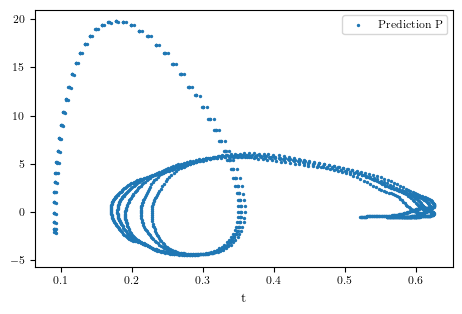

(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.    , 0.0938], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.9970674, 0.0945   ], dtype=float32)>)

In [168]:
c=0
d=-1
plt.scatter( p[c:d],phi[c:d], s=2, label='Prediction P')
# plt.scatter( s[c:d], np.exp(phi[c:d]), s=2, label='Prediction S')
# plt.plot( a[c:d], phi_p[c:d], label='Prediction S')


plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# #plt.savefig('figures/P_phi.pdf')
plt.show()
X_star_tf[c:d][0], X_star_tf[c:d][-1]

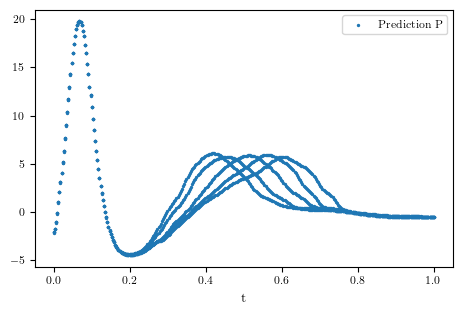

(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.    , 0.0938], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.9970674, 0.0945   ], dtype=float32)>)

In [199]:
c=0
d=-1
plt.scatter( t,phi, s=2, label='Prediction P')
# plt.scatter( s[c:d], np.exp(phi[c:d]), s=2, label='Prediction S')
# plt.plot( a[c:d], phi_p[c:d], label='Prediction S')


plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# #plt.savefig('figures/P_phi.pdf')
plt.show()
X_star_tf[c:d][0], X_star_tf[c:d][-1]

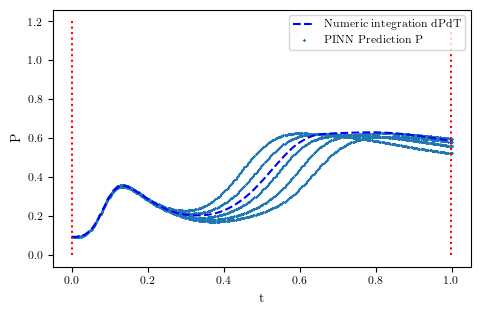

In [170]:
plt.plot(T_int, P_int, color='blue', linestyle='--', label='Numeric integration dPdT')
# plt.plot(T_int, S_int, color='orange', linestyle='--', label='Numeric integration dSdT')




plt.scatter(X_star_tf[:,0], p, marker='x', s=1,  label='PINN Prediction P')
# plt.scatter(X_star_tf[:,0], s, marker='x', s=1,  label='PINN Prediction S')


plt.vlines(X_star_tf[c:d][:,0][0],0,1.2, color='red', linestyle=':')
plt.vlines(X_star_tf[c:d][:,0][-1],0,1.2, color='red', linestyle=':')


plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()

In [171]:
# Create and train the PySR model
model= PySRRegressor(
    niterations=500,
    binary_operators=["+", "*", "inv(x, y) = x/(x + y)"],
    # unary_operators=["inv(x) = 1/x"],
    # unary_operators=["exp","inv(x) = 1/x"],
    extra_sympy_mappings={"inv": lambda x, y: x/(x+y),},
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    complexity_of_variables=1,
    complexity_of_constants=1,
    complexity_of_operators={"inv": 3},
    parsimony=0.000001,
    # select_k_features=1,
    # constraints={"constant": 0},
    maxsize=30,
    progress=True  # Show progress during training
)

In [172]:
# p1s=tf.concat([p1[c:d], s[c:d]], axis=1)

min_cols_phi= tf.math.reduce_min(phi[c:d], axis=0)
max_cols_phi= tf.math.reduce_max(phi[c:d], axis=0)

phi_scaled = (phi[c:d]-min_cols_phi)/(max_cols_phi-min_cols_phi)
PT_tf=tf.concat([p[c:d], t[c:d]],1)

model.fit( PT_tf,phi_scaled)
print(model)


[ Info: Started!



Expressions evaluated per second: 9.720e+04
Head worker occupation: 32.3%
Progress: 211 / 7500 total iterations (2.813%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
3           3.997e-02  5.314e+00  y = 0.51892 * 0.50092
5           3.629e-02  4.838e-02  y = (x₁ + -1.8109) * -0.19777
7           3.508e-02  1.695e-02  y = 0.46697 * inv(0.49597, x₁)
9           3.350e-02  2.294e-02  y = (0.42718 * inv(0.11225, x₁)) + 0.14935
13          3.282e-02  5.162e-03  y = inv(0.61865, inv(x₁ * x₁, 0.088747)) * 0.47434
19          2.474e-02  4.708e-02  y = inv(x₁ * 0.60074, inv(((-0.38311 + x₁) + x₁) * x₁, 0.12332...
                                  ) + x₀)
23          1.928e-02  6.235e-02  y = inv(x₀, (inv(inv(x₁ * (x₁ + (x₁ + -0.27207)), 0.18628), 0....
                                  20794) + x₀) + 0.18628)
27          1.800e-02  1.726e-02  y = inv(x₀, ((inv(inv(x₁ * (x₁ + (x₁ + -0

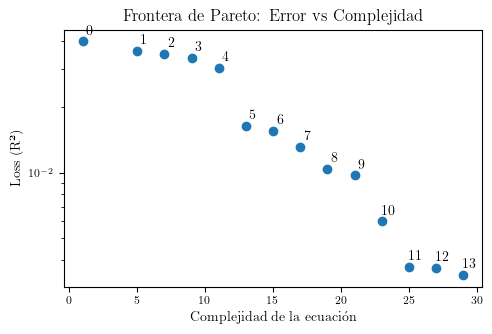

In [173]:
# Extraer las métricas de las ecuaciones
equations_df = model.equations_
# Obtener la complejidad y la puntuación (score) de cada ecuación
complejidades = equations_df['complexity']
errores = equations_df['loss']  # Por ejemplo, error MSE o cualquier métrica utilizada

# Crear el gráfico de dispersión
plt.scatter(complejidades, errores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, errores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')

# Añadir etiquetas y título
plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Loss (R²)')
plt.title('Frontera de Pareto: Error vs Complejidad')

# Mostrar gráfico
plt.yscale('log')
plt.show()

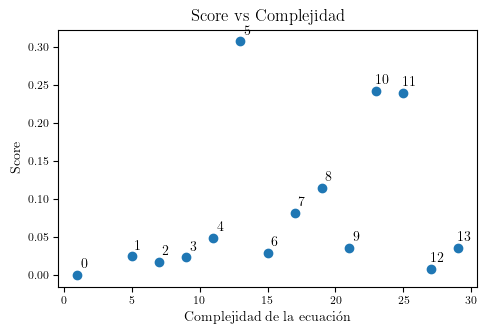

In [174]:
# Extraer complejidad y score
complejidades = equations_df['complexity']
scores = equations_df['score']

# Graficar score vs complejidad
plt.scatter(complejidades, scores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, scores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')


plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Score')
plt.title('Score vs Complejidad')
plt.show()


In [175]:
equations_df


,complexity,loss,score,equation,sympy_format,lambda_format
0,1,0.039974,0.000000,0.2599335,0.259933500000000,PySRFunction(X=>0.259933500000000)
1,5,0.036274,0.024282,0.36498076 + (-0.21021816 * x1),0.36498076 - 0.21021816*x1,PySRFunction(X=>0.36498076 - 0.21021816*x1)
2,7,0.035077,0.016769,"inv(0.4959531, x1) * 0.46694982",(0.4959531/(x1 + 0.4959531))*0.46694982,PySRFunction(X=>(0.4959531/(x1 + 0.4959531))*0...
3,9,0.033505,0.022938,"0.57652307 + (inv(x1, 0.11291306) * -0.42742646)",0.57652307 + (x1/(x1 + 0.11291306))*(-0.42742646),PySRFunction(X=>0.57652307 + (x1/(x1 + 0.11291...
4,11,0.030364,0.049212,"0.19978525 + (0.39872497 * inv(0.011018529, x1...",0.19978525 + 0.39872497*(0.011018529/(x1*x1 + ...,PySRFunction(X=>0.19978525 + 0.39872497*(0.011...
5,13,0.016414,0.307563,"0.17241037 + (0.17241037 * inv(0.005405972, x1...",0.17241037 + 0.17241037*(0.005405972/(x1*(x1 -...,PySRFunction(X=>0.17241037 + 0.17241037*(0.005...
6,15,0.015500,0.028637,"inv(1.1397458, inv((x1 + -0.12553136) * x1, 0....",(1.1397458/(x1*(x1 - 0.12553136)/(x1*(x1 - 0.1...,PySRFunction(X=>(1.1397458/(x1*(x1 - 0.1255313...
7,17,0.013153,0.082119,"(-0.39040816 * inv((x1 + -0.13082498) * x1, 0....",-0.39040816*x1*(x1 - 0.13082498)/(x1*(x1 - 0.1...,PySRFunction(X=>-0.39040816*x1*(x1 - 0.1308249...
8,19,0.010459,0.114556,"(-0.34906232 * (inv((x1 + -0.13795562) * x1, 0...",x1/(x1 + 0.23801649) - 0.34906232*(x0 + x1*(x1...,PySRFunction(X=>x1/(x1 + 0.23801649) - 0.34906...
9,21,0.009732,0.036056,(-0.34906232 * (inv(x1 * ((x1 + -0.13260941) *...,x1/(x1 + 0.21798196) - 0.34906232*(x0 + 1.0959...,PySRFunction(X=>x1/(x1 + 0.21798196) - 0.34906...


In [176]:
for i in range(len(equations_df)):
    print(i, sympy.simplify(model.sympy(i))*(max_cols_phi-min_cols_phi)+min_cols_phi)

0 1.84707752466583
1 4.39013133986878 - 5.08910078961548*x1
2 -4.44556522369385 + 5.60636854118783/(x1 + 0.4959531)
3 24.2086639404297*(0.14909661*x1 + 0.0650969839942942)/(x1 + 0.11291306) - 4.44556522369385
4 24.2086639404297*(0.19978525*x1**2 + 0.00659470221586638)/(x1**2 + 0.011018529) - 4.44556522369385
5 24.2086639404297*(0.17241037*x1*(x1 - 0.12884566) + 0.00186409126545928)/(x1*(x1 - 0.12884566) + 0.005405972) - 4.44556522369385
6 24.2086639404297*(0.3973256435922*x1*(x1 - 0.12553136) + 0.00365217599403257)/(2.1397458*x1*(x1 - 0.12553136) + 0.0104764248600368) - 4.44556522369385
7 24.2086639404297*x1*(x1*(x1 - 0.13082498) - 0.39040816*(x0 + x1)*(x1 - 0.13082498) + 0.00681312)/((x0 + x1)*(x1*(x1 - 0.13082498) + 0.00681312)) - 4.44556522369385
8 -8.45033239914673*x0 - 8.45033239914673*x1*(x1 - 0.13795562)/(x1*(x1 - 0.13795562) + 0.006749984) + 24.2086639404297*x1/(x1 + 0.23801649) - 4.44556522369385
9 -8.45033239914673*x0 - 9.26089842327176*x1*(x1 - 0.13260941)/(1.0959212*x1*(x1 

In [177]:
for i in range(len(equations_df)):
    print(i, sympy.expand(model.sympy(i))*(max_cols_phi-min_cols_phi)+min_cols_phi)

0 1.84707752466583
1 4.39013133986878 - 5.08910078961548*x1
2 -4.44556522369385 + 5.60636854118783/(x1 + 0.4959531)
3 -10.3474235293875*x1/(x1 + 0.11291306) + 9.51128803184097
4 0.390968753810882 + 0.106357439840495/(x1**2 + 0.011018529)
5 -0.271740516518707 + 0.022563579499897/(x1**2 - 0.12884566*x1 + 0.005405972)
6 -4.44556522369385 + 9.61872298063851/(x1**2/(x1**2 - 0.12553136*x1 + 0.009191896) - 0.12553136*x1/(x1**2 - 0.12553136*x1 + 0.009191896) + 1.1397458)
7 -9.4512599450415*x1**2/(x1**2 - 0.13082498*x1 + 0.00681312) + 1.23646089328486*x1/(x1**2 - 0.13082498*x1 + 0.00681312) + 24.2086639404297*x1/(x0 + x1) - 4.44556522369385
8 -8.45033239914673*x0 - 8.45033239914673*x1**2/(x1**2 - 0.13795562*x1 + 0.006749984) + 1.16577084533037*x1/(x1**2 - 0.13795562*x1 + 0.006749984) + 24.2086639404297*x1/(x1 + 0.23801649) - 4.44556522369385
9 -8.45033239914673*x0 - 9.26089842327176*x1**2/(1.0959212*x1**2 - 0.145329463738492*x1 + 0.006749984) + 1.22808227598*x1/(1.0959212*x1**2 - 0.145329463738

In [178]:
for i in range(len(equations_df)):
    print(i, sympy.factor(model.sympy(i))*(max_cols_phi-min_cols_phi)+min_cols_phi)

0 1.84707752466583
1 4.39013133986878 - 5.08910078961548*x1
2 -4.44556522369385 + 5.60636854118783/(1.0*x1 + 0.4959531)
3 -4.44556522369385 + 3.60942972614731*(1.0*x1 + 0.43660941717115)/(1.0*x1 + 0.11291306)
4 -4.44556522369385 + 4.83653397750473*(1.0*x1**2 + 0.0330089544441663)/(1.0*x1**2 + 0.011018529)
5 -4.44556522369385 + 4.17382470717514*(1.0*x1**2 - 0.12884566*x1 + 0.010811944)/(1.0*x1**2 - 0.12884566*x1 + 0.005405972)
6 4.49526433496844*(1.0*x1**2 - 0.12553136*x1 + 0.009191896)/(1.0*x1**2 - 0.12553136*x1 + 0.00489610721985612) - 4.44556522369385
7 -14.7574039953882*x1*(0.640441906177747*x0*x1 - 0.0837857995668656*x0 - 1.0*x1**2 + 0.13082498*x1 - 0.0111765275598177)/((x0 + x1)*(1.0*x1**2 - 0.13082498*x1 + 0.00681312)) - 4.44556522369385
8 -4.44556522369385 - 15.758331541283*(0.536245374518802*x0*x1**3 + 0.0536571787078271*x0*x1**2 - 0.0139883512212867*x0*x1 + 0.00086153584013261*x0 - 1.0*x1**3 + 0.265590861821701*x1**2 - 0.0279776306174386*x1)/((1.0*x1 + 0.23801649)*(1.0*x1**2 -

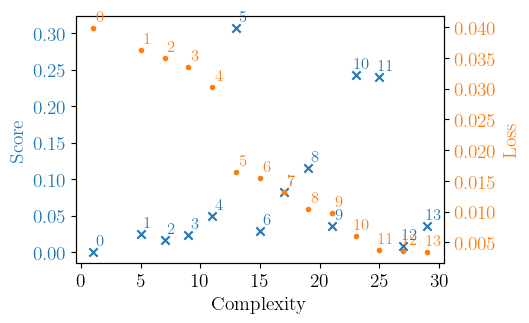

In [179]:
import matplotlib.pyplot as plt

# Obtener los colores de la paleta tab10
colors = plt.get_cmap('tab10').colors

# Crear la figura y el primer eje (izquierdo)
fig, ax1 = plt.subplots()

# Graficar score vs complejidad en el eje izquierdo usando el color tab10[0]
ax1.scatter(complejidades, scores, color=colors[0], marker='x', label='Score')
ax1.set_xlabel('Complexity', fontsize=14)
ax1.set_ylabel('Score', fontsize=14, color=colors[0])
ax1.tick_params(axis='y', labelcolor=colors[0])

# Añadir etiquetas de índice en cada punto para score
for i, (x, y) in enumerate(zip(complejidades, scores)):
    ax1.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center', fontsize=12, color=colors[0])

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

# Crear un segundo eje (derecho) que comparte el eje x
ax2 = ax1.twinx()

# Graficar errores vs complejidad en el eje derecho usando el color tab10[1]
ax2.scatter(complejidades, errores, color=colors[1], s=9, marker='o', label='Loss')
ax2.set_ylabel('Loss', fontsize=14, color=colors[1])
ax2.tick_params(axis='y', labelcolor=colors[1])

# Añadir etiquetas de índice en cada punto para errores
for i, (x, y) in enumerate(zip(complejidades, errores)):
    ax2.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center', fontsize=12, color=colors[1])

# Ajustar el gráfico para que no se corten los elementos
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig('../Img/601/Score_Loss_Complexity.png')
plt.savefig('../Img/601/Score_Loss_Complexity.pdf')
plt.savefig('../Img/601/Score_Loss_Complexity.svg')
plt.show()


In [180]:
choose=9
choose_2=10
choose_3=len(equations_df)-1

exp=model.sympy(choose)*(max_cols_phi-min_cols_phi)+min_cols_phi
exp_2=model.sympy(choose_2)*(max_cols_phi-min_cols_phi)+min_cols_phi
exp_3=model.sympy(choose_3)*(max_cols_phi-min_cols_phi)+min_cols_phi

In [181]:
sympy.factor(exp)

-11.3127663175891*(0.746973124160457*x0*x1**3 + 0.0637710003910448*x0*x1**2 - 0.0169916006441879*x0*x1 + 0.00100287994069111*x0 - 1.0*x1**3 + 0.381096204553112*x1**2 - 0.0437116219989299*x1 + 0.000527596782858712)/((1.0*x1 + 0.21798196)*(1.0*x1**2 - 0.13260941*x1 + 0.00615918735763119))

In [182]:
sympy.factor(exp_2)

-58.2740555649917*(0.420524813847191*x0*x1**3 - 0.0557655474546359*x0*x1**2 + 0.00283853576507152*x0*x1 + 0.420524813847191*x1**4 - 1.0*x1**3 + 0.395697500336953*x1**2 - 0.0418657587382796*x1 + 0.000514937459559911)/(1.0*x1**2 - 0.13260941*x1 + 0.006749984)

In [183]:
sympy.factor(exp_3)

-53.716775281991*(0.456201740330544*x0**2*x1**3 - 0.0604966436262066*x0**2*x1**2 + 0.00307935444800333*x0**2*x1 + 0.456201740330544*x0*x1**4 - 0.263112173091322*x0*x1**3 + 0.0299480802672099*x0*x1**2 - 0.00136765158204106*x0*x1 + 0.386045348756074*x1**4 - 1.0*x1**3 + 0.418777808031017*x1**2 - 0.0449077455573991*x1 + 0.000558624265387542)/(1.0*x1**2 - 0.13260941*x1 + 0.006749984)

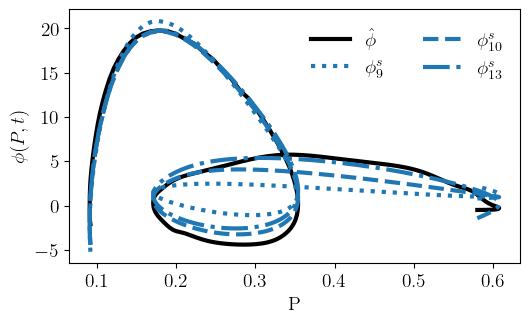

In [273]:
i=0
symb1=model.predict(tf.concat([p[L_exp*i:L_exp*(i+1)], t[L_exp*i:L_exp*(i+1)]],1),choose).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
symb2=model.predict(tf.concat([p[L_exp*i:L_exp*(i+1)], t[L_exp*i:L_exp*(i+1)]],1),choose_2).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
symb3=model.predict(tf.concat([p[L_exp*i:L_exp*(i+1)], t[L_exp*i:L_exp*(i+1)]],1),choose_3).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi

# symb1=model_phi.predict(s,choose).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
# symb2=model_phi.predict(s,choose_2).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
# symb3=model_phi.predict(s,choose_3).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi


plt.plot(p[L_exp*i:L_exp*(i+1)], phi[L_exp*i:L_exp*(i+1)],linewidth=3, color='black', label='$\hat{\phi}$')
# plt.plot(s[L_exp*i:L_exp*(i+1)], phi[L_exp*i:L_exp*(i+1)],linewidth=3, color='gray', label='$\hat{\phi}(S)$')

# plt.plot(P, phi_star, linewidth=3,linestyle='--', label='$\phi^*$')
plt.plot(p[L_exp*i:L_exp*(i+1)], symb1,linewidth=3, color=colors[0], linestyle=':', label='$\phi^s_9$')
plt.plot(p[L_exp*i:L_exp*(i+1)], symb2,linewidth=3, color=colors[0], linestyle='--', label='$\phi^s_{10}$')
plt.plot(p[L_exp*i:L_exp*(i+1)], symb3,linewidth=3, color=colors[0],linestyle='-.', label='$\phi^s_{13}$')
# plt.plot(s[L_exp*i:L_exp*(i+1)], symb1,linewidth=3, color=colors[1], linestyle=':', label='$\phi^s_2(S)$')
# plt.plot(s[L_exp*i:L_exp*(i+1)], symb2,linewidth=3, color=colors[1],linestyle='--', label='$\phi^s_{3}(S)$')
# plt.plot(s[L_exp*i:L_exp*(i+1)], symb3,linewidth=3, color=colors[1],linestyle='-.', label='$\phi^s_{14}(S)$')



# plt.legend(fontsize=14, ncols=2, frameon=False,  bbox_to_anchor=(1, 1))
plt.legend(fontsize=14, ncols=2, frameon=False)


plt.xlabel('P', fontsize=14, color='black')

# plt.xlabel('P', fontsize=14)
plt.ylabel('$\phi(P, t)$', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Img/601/Result_phi_s.png')
plt.savefig('../Img/601/Result_phi_s.pdf')
plt.savefig('../Img/601/Result_phi_s.svg')
plt.show()


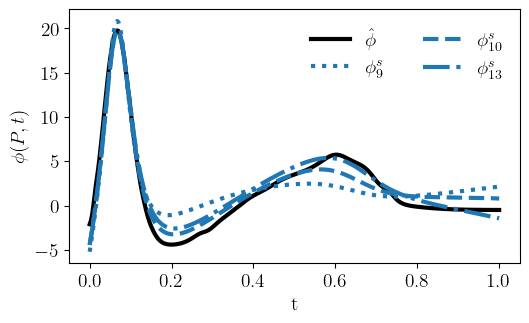

In [272]:
i=0
symb1=model.predict(tf.concat([p[L_exp*i:L_exp*(i+1)], t[L_exp*i:L_exp*(i+1)]],1),choose).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
symb2=model.predict(tf.concat([p[L_exp*i:L_exp*(i+1)], t[L_exp*i:L_exp*(i+1)]],1),choose_2).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
symb3=model.predict(tf.concat([p[L_exp*i:L_exp*(i+1)], t[L_exp*i:L_exp*(i+1)]],1),choose_3).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi

# symb1=model_phi.predict(s,choose).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
# symb2=model_phi.predict(s,choose_2).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
# symb3=model_phi.predict(s,choose_3).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi


plt.plot(t[L_exp*i:L_exp*(i+1)], phi[L_exp*i:L_exp*(i+1)],linewidth=3, color='black', label='$\hat{\phi}$')
# plt.plot(s[L_exp*i:L_exp*(i+1)], phi[L_exp*i:L_exp*(i+1)],linewidth=3, color='gray', label='$\hat{\phi}(S)$')

# plt.plot(P, phi_star, linewidth=3,linestyle='--', label='$\phi^*$')
plt.plot(t[L_exp*i:L_exp*(i+1)], symb1,linewidth=3, color=colors[0], linestyle=':', label='$\phi^s_9$')
plt.plot(t[L_exp*i:L_exp*(i+1)], symb2,linewidth=3, color=colors[0], linestyle='--', label='$\phi^s_{10}$')
plt.plot(t[L_exp*i:L_exp*(i+1)], symb3,linewidth=3, color=colors[0],linestyle='-.', label='$\phi^s_{13}$')
# plt.plot(s[L_exp*i:L_exp*(i+1)], symb1,linewidth=3, color=colors[1], linestyle=':', label='$\phi^s_2(S)$')
# plt.plot(s[L_exp*i:L_exp*(i+1)], symb2,linewidth=3, color=colors[1],linestyle='--', label='$\phi^s_{3}(S)$')
# plt.plot(s[L_exp*i:L_exp*(i+1)], symb3,linewidth=3, color=colors[1],linestyle='-.', label='$\phi^s_{14}(S)$')



# plt.legend(fontsize=14, ncols=2, frameon=False,  bbox_to_anchor=(1, 1))
plt.legend(fontsize=14, ncols=2, frameon=False)


plt.xlabel('t', fontsize=14, color='black')

# plt.xlabel('P', fontsize=14)
plt.ylabel('$\phi(P, t)$', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Img/601/Result_phi_t.png')
plt.savefig('../Img/601/Result_phi_t.pdf')
plt.savefig('../Img/601/Result_phi_t.svg')
plt.show()


In [186]:
Nt=10000
P_symb_1=np.zeros(Nt)
P_symb_2=np.zeros(Nt)
P_symb_3=np.zeros(Nt)
# S_symb_1=np.zeros(Nt)
# S_symb_2=np.zeros(Nt)
# S_symb_3=np.zeros(Nt)
T_symb=np.zeros(Nt)
dt=0.0001

P_symb_1[0]=P_symb_2[0]=P_symb_3[0]=np.mean(uu0) #Initial conditions
# S_symb_1[0]=S_symb_2[0]=S_symb_3[0]=np.array(tf.exp(u_pred[0,1:2])) #Initial conditions

T_symb[0]=0

for i in range(1,Nt):
    PT=tf.concat([tf.convert_to_tensor(P_symb_1[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(T_symb[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    PHI_S=model.predict(PT,choose).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
    P_symb_1[i]=P_symb_1[i-1]+(PHI_S*P_symb_1[i-1])*dt
    # S_symb_1[i]=S_symb_1[i-1]-P_symb_3[i-1]*S_symb_1[i-1]*np.array(m)*dt

    PT=tf.concat([tf.convert_to_tensor(P_symb_2[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(T_symb[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    PHI_S=model.predict(PT,choose_2).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
    P_symb_2[i]=P_symb_2[i-1]+(PHI_S*P_symb_2[i-1])*dt
    # S_symb_2[i]=S_symb_2[i-1]-P_symb_2[i-1]*S_symb_2[i-1]*np.array(m)*dt

    PT=tf.concat([tf.convert_to_tensor(P_symb_3[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(T_symb[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    PHI_S=model.predict(PT,choose_3).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
    P_symb_3[i]=P_symb_3[i-1]+(PHI_S*P_symb_3[i-1])*dt
    # S_symb_3[i]=S_symb_3[i-1]-P_symb_3[i-1]*S_symb_3[i-1]*np.array(m)*dt

    T_symb[i]=T_symb[i-1]+dt

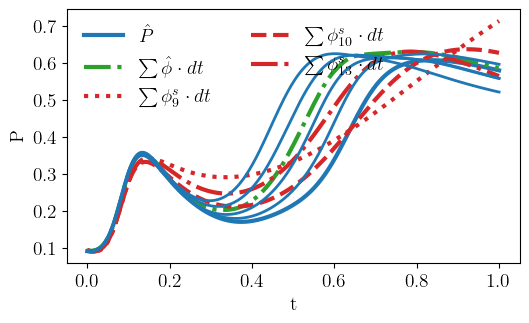

In [187]:
i=0
plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], p[L_exp*i:L_exp*(i+1)], linewidth=3, label='$\hat{P}$')
# plt.plot(T, P, linestyle='--',linewidth=3, label='$P^*$')
plt.plot(T_int, P_int, color=colors[2], linestyle='-.',linewidth=3, label='$\sum \hat{\phi} \cdot dt$')
plt.plot(T_symb, P_symb_1, color=colors[3],linestyle=':',linewidth=3, label='$\sum \phi^s_{9} \cdot dt$')
plt.plot(T_symb, P_symb_2, color=colors[3],linestyle='--',linewidth=3, label='$\sum \phi^s_{10} \cdot dt$')
plt.plot(T_symb, P_symb_3, color=colors[3],linestyle='-.',linewidth=3, label='$\sum \phi^s_{13} \cdot dt$')

for i in range(1, N_exp):
    plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], p[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[0])
    # plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], s[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[1])

    # plt.scatter(X_u_train[:,0], P_train, marker='x',  color='black')


plt.legend(fontsize=14, ncols=2, frameon=False)
plt.xlabel('t', fontsize=14)
plt.ylabel('P', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 


plt.tight_layout()
plt.savefig('../Img/601/Result_int_s_p.png')
plt.savefig('../Img/601/Result_int_s_p.pdf')
plt.savefig('../Img/601/Result_int_s_p.svg')
plt.show()

In [188]:
sdfghjkl

NameError: name 'sdfghjkl' is not defined

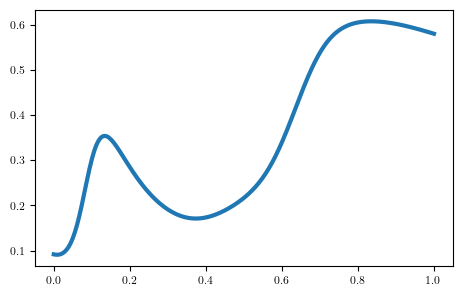

In [208]:
plt.plot(t[:L_exp], p[:L_exp], linewidth=3, label='$\hat{P}$')

In [209]:
# T_symb=np.linspace(0,1,1000)
# P0=np.repeat(np.mean(P_exp[::L_exp]), len(T_symb))
# X_star_symb=np.vstack((T_symb,P0)).T
# X_star_symb_tf=tf.convert_to_tensor(X_star_symb, dtype=tf.float32)  
# u_pred = predict(X_star_symb_tf, W_p, b_p)

# ## Evaluating unknown function
# p_symb=p[:L_exp]
# t_symb=t[:L_exp]
p_symb=tf.convert_to_tensor(P_int.reshape([-1,1]), dtype=tf.float32)
t_symb=tf.convert_to_tensor(T_int.reshape([-1,1]), dtype=tf.float32)

# phi_s=tf.exp(net(tf.concat([p_symb, s_symb, a_symb],1), W_a, b_a))
phi_symb=net(tf.concat([p_symb, t_symb],1), W_phi, b_phi)

In [210]:
import numpy as np
import pysindy as ps

# Supongamos que PT_tf tiene las columnas [P, T] y phi_scaled es un array
P = p_symb  # Primera columna (P)
T = t_symb  # Segunda columna (T)
min_cols_phi_p= tf.math.reduce_min(phi_symb, axis=0)
max_cols_phi_p= tf.math.reduce_max(phi_symb, axis=0)

phi_scaled = (phi_symb-min_cols_phi_p)/(max_cols_phi_p-min_cols_phi_p)

phi_scaled = np.array(phi_scaled)[:,0] # Datos de phi_scaled

# Combinar P y T en una matriz de entrada
X = np.column_stack([P, T])

In [261]:
# Configurar la librería de funciones
library = ps.PolynomialLibrary(degree=4)  # Hasta tercer grado polinomial


# Crear el modelo SINDy con optimizador
model_s = ps.SINDy(feature_library=library, optimizer=ps.STLSQ(threshold=0.2))
# Ajustar el modelo a los datos
model_s.fit(X, x_dot=phi_scaled)  # Aquí phi_scaled se interpreta como "derivadas" del sistema

# Imprimir la ecuación aprendida
model_s.print()

(x0)' = -0.174 1 + 34.644 x1 + 24.816 x0^2 + -146.163 x0 x1 + -132.980 x1^2 + 383.056 x0 x1^2 + 184.262 x1^3 + -212.975 x0^4 + 798.596 x0^3 x1 + -1147.616 x0^2 x1^2 + 334.724 x0 x1^3 + -170.692 x1^4


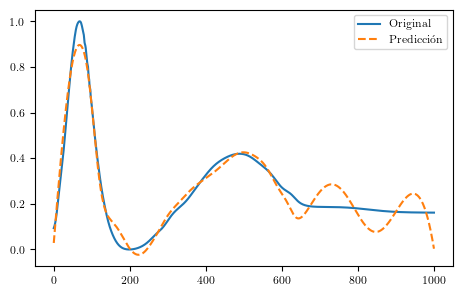

In [262]:
predicted_phi = model_s.predict(X)

# Comparar predicción con phi_scaled original
import matplotlib.pyplot as plt
plt.plot(phi_scaled, label="Original")
plt.plot(predicted_phi, label="Predicción", linestyle="dashed")
plt.legend()
plt.show()

In [263]:
Nt=10000
P_symb_s=np.zeros(Nt)
# S_symb_1=np.zeros(Nt)
# S_symb_2=np.zeros(Nt)
# S_symb_3=np.zeros(Nt)
T_symb=np.zeros(Nt)
dt=0.0001

P_symb_s[0]=np.mean(uu0) #Initial conditions
# S_symb_1[0]=S_symb_2[0]=S_symb_3[0]=np.array(tf.exp(u_pred[0,1:2])) #Initial conditions

T_symb[0]=0

for i in range(1,Nt):
    PT=tf.concat([tf.convert_to_tensor(P_symb_s[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(T_symb[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    PHI_S=model_s.predict(PT).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
    P_symb_s[i]=P_symb_s[i-1]+(PHI_S*P_symb_s[i-1])*dt
    T_symb[i]=T_symb[i-1]+dt

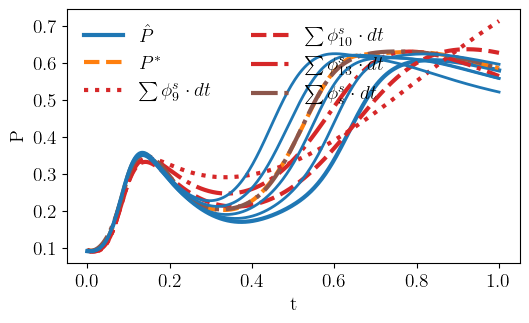

In [276]:
i=0
plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], p[L_exp*i:L_exp*(i+1)], linewidth=3, label='$\hat{P}$')
plt.plot(T, P, linestyle='--',linewidth=3, label='$P^*$')
# plt.plot(T_int, P_int, color=colors[2], linestyle='-.',linewidth=3, label='$\sum \hat{\phi} \cdot dt$')
plt.plot(T_symb, P_symb_1, color=colors[3],linestyle=':',linewidth=3, label='$\sum \phi^s_9 \cdot dt$')
plt.plot(T_symb, P_symb_2, color=colors[3],linestyle='--',linewidth=3, label='$\sum \phi^s_{10} \cdot dt$')
plt.plot(T_symb, P_symb_3, color=colors[3],linestyle='-.',linewidth=3, label='$\sum \phi^s_{13} \cdot dt$')
plt.plot(T_symb, P_symb_s, color=colors[5],linestyle='-.',linewidth=3, label='$\sum \phi^s_{s} \cdot dt$')

for i in range(1, N_exp):
    plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], p[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[0])
    # plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], s[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[1])

    # plt.scatter(X_u_train[:,0], P_train, marker='x',  color='black')


plt.legend(fontsize=14, ncols=2, frameon=False)
plt.xlabel('t', fontsize=14)
plt.ylabel('P', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 


plt.tight_layout()
plt.savefig('../Img/601/Result_int_sindy.png')
plt.savefig('../Img/601/Result_int_sindy.pdf')
plt.savefig('../Img/601/Result_int_sindy.svg')
plt.show()

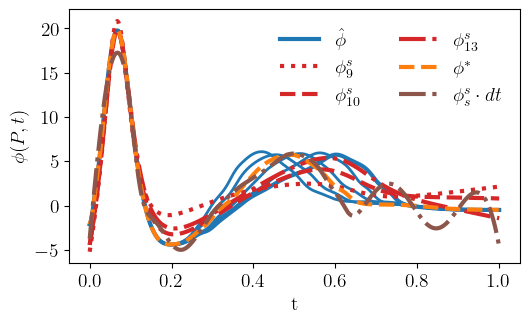

In [275]:
i=0
symb1=model.predict(tf.concat([p[L_exp*i:L_exp*(i+1)], t[L_exp*i:L_exp*(i+1)]],1),choose).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
symb2=model.predict(tf.concat([p[L_exp*i:L_exp*(i+1)], t[L_exp*i:L_exp*(i+1)]],1),choose_2).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
symb3=model.predict(tf.concat([p[L_exp*i:L_exp*(i+1)], t[L_exp*i:L_exp*(i+1)]],1),choose_3).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi

# symb1=model_phi.predict(s,choose).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
# symb2=model_phi.predict(s,choose_2).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
# symb3=model_phi.predict(s,choose_3).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi


plt.plot(t[L_exp*i:L_exp*(i+1)], phi[L_exp*i:L_exp*(i+1)],linewidth=3, color=colors[0], label='$\hat{\phi}$')
for i in range(1, N_exp):
    plt.plot(t[L_exp*i:L_exp*(i+1)], phi[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[0])
# plt.plot(s[L_exp*i:L_exp*(i+1)], phi[L_exp*i:L_exp*(i+1)],linewidth=3, color='gray', label='$\hat{\phi}(S)$')

# plt.plot(P, phi_star, linewidth=3,linestyle='--', label='$\phi^*$')
plt.plot(t[L_exp*i:L_exp*(i+1)], symb1,linewidth=3, color=colors[3], linestyle=':', label='$\phi^s_9$')
plt.plot(t[L_exp*i:L_exp*(i+1)], symb2,linewidth=3, color=colors[3], linestyle='--', label='$\phi^s_{10}$')
plt.plot(t[L_exp*i:L_exp*(i+1)], symb3,linewidth=3, color=colors[3],linestyle='-.', label='$\phi^s_{13}$')
plt.plot(T, phi_symb, linestyle='--',linewidth=3, color=colors[1], label='$\phi^*$')
plt.plot(T, predicted_phi*(max_cols_phi-min_cols_phi)+min_cols_phi, color=colors[5],linestyle='-.',linewidth=3, label='$\phi^s_{s} \cdot dt$')

# plt.plot(s[L_exp*i:L_exp*(i+1)], symb1,linewidth=3, color=colors[1], linestyle=':', label='$\phi^s_2(S)$')
# plt.plot(s[L_exp*i:L_exp*(i+1)], symb2,linewidth=3, color=colors[1],linestyle='--', label='$\phi^s_{3}(S)$')
# plt.plot(s[L_exp*i:L_exp*(i+1)], symb3,linewidth=3, color=colors[1],linestyle='-.', label='$\phi^s_{14}(S)$')



# plt.legend(fontsize=14, ncols=2, frameon=False,  bbox_to_anchor=(1, 1))
plt.legend(fontsize=14, ncols=2, frameon=False)


plt.xlabel('t', fontsize=14, color='black')

# plt.xlabel('P', fontsize=14)
plt.ylabel('$\phi(P, t)$', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  

plt.tight_layout()
plt.savefig('../Img/601/Result_phi_sindy_t.png')
plt.savefig('../Img/601/Result_phi_sindy_t.pdf')
plt.savefig('../Img/601/Result_phi_sindy_t.svg')
plt.show()

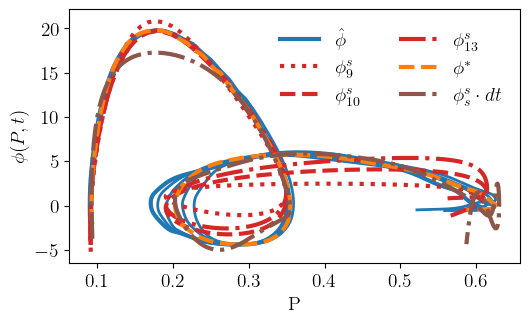

In [274]:
i=0
symb1=model.predict(tf.concat([p[L_exp*i:L_exp*(i+1)], t[L_exp*i:L_exp*(i+1)]],1),choose).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
symb2=model.predict(tf.concat([p[L_exp*i:L_exp*(i+1)], t[L_exp*i:L_exp*(i+1)]],1),choose_2).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
symb3=model.predict(tf.concat([p[L_exp*i:L_exp*(i+1)], t[L_exp*i:L_exp*(i+1)]],1),choose_3).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi

# symb1=model_phi.predict(s,choose).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
# symb2=model_phi.predict(s,choose_2).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi
# symb3=model_phi.predict(s,choose_3).reshape([-1,1])*(max_cols_phi-min_cols_phi)+min_cols_phi


plt.plot(p[L_exp*i:L_exp*(i+1)], phi[L_exp*i:L_exp*(i+1)],linewidth=3, color=colors[0], label='$\hat{\phi}$')
for i in range(1, N_exp):
    plt.plot(p[L_exp*i:L_exp*(i+1)], phi[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[0])
# plt.plot(s[L_exp*i:L_exp*(i+1)], phi[L_exp*i:L_exp*(i+1)],linewidth=3, color='gray', label='$\hat{\phi}(S)$')

# plt.plot(P, phi_star, linewidth=3,linestyle='--', label='$\phi^*$')
plt.plot(p[L_exp*i:L_exp*(i+1)], symb1,linewidth=3, color=colors[3], linestyle=':', label='$\phi^s_9$')
plt.plot(p[L_exp*i:L_exp*(i+1)], symb2,linewidth=3, color=colors[3], linestyle='--', label='$\phi^s_{10}$')
plt.plot(p[L_exp*i:L_exp*(i+1)], symb3,linewidth=3, color=colors[3],linestyle='-.', label='$\phi^s_{13}$')
plt.plot(P, phi_symb, linestyle='--',linewidth=3, color=colors[1], label='$\phi^*$')
plt.plot(P, predicted_phi*(max_cols_phi-min_cols_phi)+min_cols_phi, color=colors[5],linestyle='-.',linewidth=3, label='$\phi^s_{s} \cdot dt$')

# plt.plot(s[L_exp*i:L_exp*(i+1)], symb1,linewidth=3, color=colors[1], linestyle=':', label='$\phi^s_2(S)$')
# plt.plot(s[L_exp*i:L_exp*(i+1)], symb2,linewidth=3, color=colors[1],linestyle='--', label='$\phi^s_{3}(S)$')
# plt.plot(s[L_exp*i:L_exp*(i+1)], symb3,linewidth=3, color=colors[1],linestyle='-.', label='$\phi^s_{14}(S)$')



# plt.legend(fontsize=14, ncols=2, frameon=False,  bbox_to_anchor=(1, 1))
plt.legend(fontsize=14, ncols=2, frameon=False)


# plt.xlabel('t', fontsize=14, color='black')

plt.xlabel('P', fontsize=14)
plt.ylabel('$\phi(P, t)$', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  

plt.tight_layout()
plt.savefig('../Img/601/Result_phi_sindy_p.png')
plt.savefig('../Img/601/Result_phi_sindy_p.pdf')
plt.savefig('../Img/601/Result_phi_sindy_p.svg')
plt.show()